Test implementation of a Variational Autoencoder

In [414]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, losses

from keras.datasets import mnist
from keras.models import Model

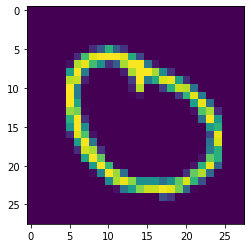

In [415]:
(x_train, _), (x_test, y_test) = mnist.load_data()

def preprocess_images(images, discrete=True):
    # Normalize and make into tensor
    images = images.reshape((images.shape[0], 28, 28, 1)) /255.

    if discrete:
        # Round pixel values to 0 or 1. Allows use of cross entropy loss?
        return np.where(images > .5, 1.0, 0.0).astype('float32')
    else:
        # No discretization of pixel values
        return images.astype('float32')

# Look at random image (before binarization)
img_nbr = np.random.randint(0, len(x_train)+1)
plt.imshow(x_train[img_nbr, :, :])
plt.show()

# Don't discretize if continuous bernoulli loss is being used
x_train = preprocess_images(x_train, discrete=False) # shape: (nbr_images, 28, 28, 1)
x_test = preprocess_images(x_test, discrete=False)

In [416]:
# Do we need to batch and shuffle the data?
# Maybe in we dont use the fit() function, we need to do it manually

train_size = x_train.shape[0]
batch_size = 32 # Size of batches in gradient update / training step?
test_size = x_test.shape[0]
print(x_test.shape)

train_dataset = (tf.data.Dataset.from_tensor_slices(x_train).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).shuffle(test_size).batch(batch_size))

tf.print(test_dataset)

(10000, 28, 28, 1)
<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


Alternative functional approach

https://keras.io/examples/generative/vae/


In [417]:
# Define model
# https://www.tensorflow.org/tutorials/generative/cvae

class VAE(Model):
    def __init__(self, latent_dim=2, dropout_rate=0.1):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=(28, 28, 1)),

            layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            layers.Dropout(dropout_rate),
            
            layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            layers.Dropout(dropout_rate),
            
            layers.Flatten(),

            # 2D latent space -> 2D mean, 2D var ->
            # mean1, mean2, log_var1, log_var2 -> 2 + 2
            layers.Dense(latent_dim + latent_dim),
        ])

        self.decoder = keras.Sequential([
            # Point z sampled from distrs. will be 2D
            layers.InputLayer(input_shape=(latent_dim,)),

            # BIG dense that takes 2d z input
            layers.Dense(units=7*7*32, activation='relu'),

            # Reshape into tensor
            layers.Reshape(target_shape=(7, 7, 32)),

            # Transp. Conv: padding same? no upsampling?
            # Pads the input so output is same dim?
            layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(2, 2), padding='same',
                activation='relu'),
            layers.Dropout(dropout_rate),
            
            layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=(2, 2), padding='same',
                activation='relu'),
            layers.Dropout(dropout_rate),

            # Last layer, no activation / linear?
            layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding='same'),
        ])

    # Decorator: turns py code into graph
    # Use for computationally expensive functions
    @tf.function
    def sample(self, eps=None):
        # Sample 100 random z?
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x, training=None):
        mean, logvar = tf.split(
            self.encoder(x, training=training), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        # Returns a z sampled from N(mean, var)
        
        # Added stuff to deal with batches?
        # Causes some error with @tf.function though?
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        
        eps = tf.random.normal(shape=(batch, dim))
        return mean + eps * tf.exp(logvar * .5) # mu + eps * std

    def decode(self, z, apply_sigmoid=False, training=None):
        # Decode latent z into image
        # apply_sigmoid: outputs pixel values [0, 1]
        logits = self.decoder(z, training=training) # logits vals: (-inf, inf)?
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    # Needed for summary
    def call(self, x, training=None):
        mean, logvar = self.encode(x, training=training)
        sampled_z = self.reparameterize(mean, logvar)
        decoded_img = self.decode(sampled_z, training=training)
        return decoded_img
    
    def summary(self):
        # Uses 'call' to initialize something in TF backend 
        # that allows for 'summary'
        x = keras.Input(shape=(28, 28, 1))
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()
        


In [418]:
import tensorflow_probability as tpb # For Bernoulli distr. (tensorflow==2.5)

# Defining loss function

# learning rate: 1e-4
optimizer = tf.keras.optimizers.Adam(1e-4)

# Returns logarithm of normal pdf w. 
# mean, logvar for each value in 'sample'
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)

    # log(norm_pdf(sample; mean, var))
    values = -.5 * (logvar + log2pi + 
    (sample - mean)**2 * tf.exp(-logvar))

    # 'values' consists of log pdf in both latent x- and y-directions
    # 'reduce_sum' sums these up to one value
    return tf.reduce_sum(values, axis=raxis)


def compute_loss(model, x, loss_type='bce'):
    # 'bce': Binary cross entropy (defualt)
    # 'bernoulli': Bernoulli loss
    # 'cb': continous bernoulli loss
    
    if loss_type == 'bernoulli':
        return compute_bernoulli_loss(model, x)
    
    if loss_type == 'cb':
        return continuous_bernoulli_loss(model, x)
    
    # Compute ELBO loss w.r.t a sample x (or batch?)
    mean, logvar = model.encode(x, training=True) # Training True: enable dopout (handled by Keras?)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z, training=True)

    # Loss between input & output (reconstruction). Binary cross entropy
    # indep. for each pixel?
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=x_logit, labels=x)
    
    log_px_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    log_pz = log_normal_pdf(z, 0., 0.)
    log_qz_x = log_normal_pdf(z, mean, logvar)

    # 'mean' to approx. expectation
    return -tf.reduce_mean(log_px_z + log_pz - log_qz_x)


def compute_bernoulli_loss(model, x):
    mean, logvar = model.encode(x, training=True)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z, training=True)
    
    # Likelihood over pixels is Bernoulli given by logits from decoder
    log_px_z_distr = tpb.distributions.Bernoulli(logits=x_logit)
    # Likelihood of input image given generated 
    log_px_z = tf.reduce_sum(log_px_z_distr.log_prob(x), axis=[1,2,3]) # vector of losses for each image

    # for KL divergence
    log_pz = log_normal_pdf(z, 0., 0.)
    log_qz_x = log_normal_pdf(z, mean, logvar)
    
    return -tf.reduce_mean(log_px_z + log_pz - log_qz_x)

# TODO: Add continous bernoulli loss

@tf.function
def train_step(model, x, optimizer, loss_type='bce'):
    # Computes gradients and updates weights

    # TODO: learn how gradient tape works
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, loss_type=loss_type)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [419]:
# Attempt at understanding & implementing continuous bernoulli loss used for MNIST
# VAEs. See https://arxiv.org/abs/1907.06845

def continuous_bernoulli_loss(model, x):
    # 'model': Tensorflow model object
    # 'x': data (images in MNIST case) shape=(nbr_examples, 28, 28 1),
    # i.e output from decoder
    
    # Should return a tf.Tensor object w. the loss
    
    # Cont. Bern. helper f
    def _cont_bern_log_norm(x, l_lim=0.48, u_lim=0.52):
        # returns the log normalizing constant for x in (0, l_lim) U (u_lim, 1) and a Taylor approximation in
        # [l_lim, u_lim].
        # lower & upper limit needed for numerical stability, as the function diverges for x -> 0.
        # credit: https://github.com/cunningham-lab/cb_and_cc/blob/master/cb/utils.py
        
        # if x is outside out limit, leave it be, else clip at lower lim
        cut_x = tf.where(tf.logical_or(tf.less(x, l_lim), tf.greater(x, u_lim)), x, l_lim * tf.ones_like(x))
        
        # log C(lambda)
        log_norm = tf.math.log(tf.math.abs(2.0 * tf.math.atanh(1 - 2.0 * cut_x))) - tf.math.log(tf.math.abs(1 - 2.0 * cut_x))
        
        # 4th order taylor approx around 0.5?
        taylor = tf.math.log(2.0) + 4.0 / 3.0 * tf.math.pow(x - 0.5, 2) + 104.0 / 45.0 * tf.math.pow(x - 0.5, 4)
        
        # return log norm outside interval, taylor approx inside
        return tf.where(tf.logical_or(tf.less(x, l_lim), tf.greater(x, u_lim)), log_norm, taylor)
    
    mean, logvar = model.encode(x, training=True)
    z = model.reparameterize(mean, logvar)
    x_decoded = model.decode(z, training=True, apply_sigmoid=True) # lambda(z)
    x_decoded_flat = tf.reshape(x_decoded, [x_decoded.shape[0], -1, 1]) # flatten images to 1D
    x_decoded_flat = tf.clip_by_value(x_decoded_flat, 1e-4, 1 - 1e-4)
    
    # Cont. Bernoulli normalizing constant (regularizer for sharpness?)
    # log_norm_const = tf.reduce_sum(_cont_bern_log_norm(x_decoded_flat), [1, 2])
    log_norm_const = _cont_bern_log_norm(x_decoded_flat)
    
    # Regular Bernoulli loss
    # log_px_z_distr = tpb.distributions.Bernoulli(probs=x_decoded)
    # log_px_z_old = tf.reduce_sum(log_px_z_distr.log_prob(x), axis=[1,2,3]) # vector of losses for each image
    
    x_flat = tf.reshape(x, [x.shape[0], -1, 1])
    log_p_all = x_flat * tf.math.log(x_decoded_flat) + (1 - x_flat) * tf.math.log(1 - x_decoded_flat) + log_norm_const
    
    # For each image, sum loss over all pixels. Then calc. mean over all images in batch
    log_px_z = tf.reduce_mean(tf.reduce_sum(log_p_all, axis=1))
    
    # for KL divergence
    log_pz = log_normal_pdf(z, 0., 0.)
    log_qz_x = log_normal_pdf(z, mean, logvar)
    KL = tf.reduce_mean(log_pz - log_qz_x) # Single MC estimate of KL (not averaged?)
 
    return -(log_px_z + KL)

In [420]:
# Single loss pass
model = VAE(2)

print(continuous_bernoulli_loss(model, x_test))

# for test_batch in test_dataset.take(1):
#     print(compute_loss(model, test_batch, loss='cb'))


tf.Tensor(-1.0913488, shape=(), dtype=float32)


In [421]:
# Model training

epochs = 10
latent_dim = 8
nbr_examples_to_generate = 16

# constant random latent vector
# Used for showing samples during training?
random_vector_for_generation = tf.random.normal(
    shape=[nbr_examples_to_generate, latent_dim])

model = VAE(latent_dim)

model.summary() # Doesnt specity the layers within "sequential"?

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 107,057
Trainable params: 107,057
Non-trainable params: 0
__________________________________________________________________________________________________


In [448]:
def generate_images(model, test_dataset, nbr_examples_to_generate=16, test_sample=None):
    # Generates and plots 'nbr_examples_to_generate' images.
    # Specify which samples though 'test_sample',
    # else random are picked from dataset
    
    if test_sample is not None:
        mean, logvar = model.encode(test_sample)
    else:
        # Pick random images to generate
        assert batch_size >= nbr_examples_to_generate

        for test_batch in test_dataset.take(1): # 'take' picks a random batch
            sample = test_batch[0:nbr_examples_to_generate, :, :, :] # pick 'nbr_ex..' samples
            
        mean, logvar = model.encode(sample)
        
    z = model.reparameterize(mean, logvar)
    samples = model.sample(z)
    fig = plt.figure(figsize=(6, 6))
    
    # Finds appropriate grid side length 
    # grid_len = int(np.ceil(np.log2(nbr_examples_to_generate)))
    grid_len = 4
    
    # plot sampled images
    for i in range(samples.shape[0]):
        plt.subplot(grid_len, grid_len, i + 1)
        plt.imshow(samples[i, :, :, 0])
        plt.axis('off')
    
    plt.show()

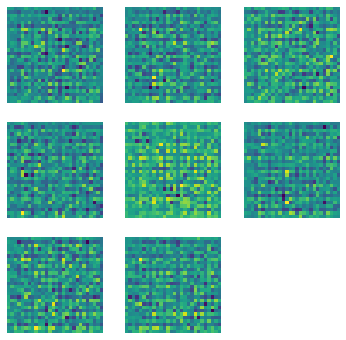

In [423]:
generate_images(model, test_dataset)

In [424]:
# Training
import time
progbar = tf.keras.utils.Progbar(len(train_dataset))

loss_type = 'cb'

for epoch in range(1, epochs+1):
    start_time = time.time()
    
    for i, training_batch in enumerate(train_dataset):
        train_step(model, training_batch, optimizer, loss_type=loss_type)
        progbar.update(i)
        
    end_time = time.time()
    
    loss = tf.keras.metrics.Mean()
    
    for test_batch in test_dataset:
        loss(compute_loss(model, test_batch, loss_type=loss_type))
    
    elbo = -loss.result()
    # display.clear_output(wait=False)
    print('\n Epoch {}/{}: Test ELBO: {:.3f}, time for epoch: {:.1f}s'.format(
        epoch, epochs, elbo, end_time - start_time))

1873/1875 [============================>.] - ETA: 0s
 Epoch 1/10: Test ELBO: 1299.828, time for epoch: 72.8s
1873/1875 [============================>.] - ETA: 0s
 Epoch 2/10: Test ELBO: 1372.378, time for epoch: 74.6s
1874/1875 [============================>.] - ETA: 0s
 Epoch 3/10: Test ELBO: 1388.652, time for epoch: 71.0s
1873/1875 [============================>.] - ETA: 0s
 Epoch 4/10: Test ELBO: 1398.368, time for epoch: 71.6s
1874/1875 [============================>.] - ETA: 0s
 Epoch 5/10: Test ELBO: 1404.906, time for epoch: 73.0s
1873/1875 [============================>.] - ETA: 0s
 Epoch 6/10: Test ELBO: 1410.149, time for epoch: 71.5s
1874/1875 [============================>.] - ETA: 0s
 Epoch 7/10: Test ELBO: 1413.962, time for epoch: 71.7s
1873/1875 [============================>.] - ETA: 0s
 Epoch 8/10: Test ELBO: 1417.334, time for epoch: 72.2s
1873/1875 [============================>.] - ETA: 0s
 Epoch 9/10: Test ELBO: 1420.199, time for epoch: 71.1s
1873/1875 [========

(16, 28, 28, 1)


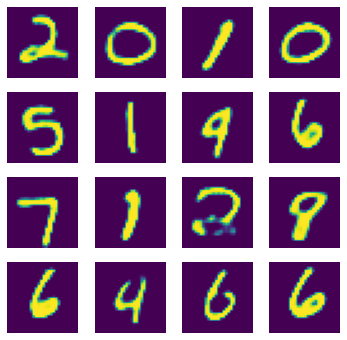

In [450]:
test_sample = next(iter(test_dataset))[:16, :, :, :]

generate_images(model, test_dataset, test_sample=test_sample)

# Continuous bernoulli examples!

In [435]:
# pick a single image from out test set

for test_batch in test_dataset.take(1):
    sample = test_batch[0:1, :, :, :]

Text(0.5, 1.0, 'difference')

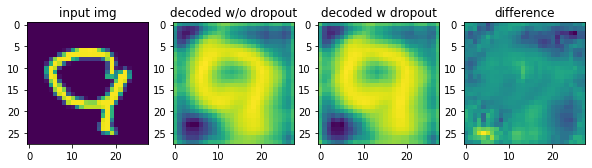

In [451]:
# Look at the difference dropout layers cause

plt.figure(figsize=(10, 10))

plt.subplot(1, 4, 1)
plt.imshow(sample[0, :, :, 0])
plt.title('input img')

out = model(sample)

plt.subplot(1, 4, 2)
plt.imshow(out[0, :, :, 0])
plt.title('decoded w/o dropout')

out_train = model(sample, training=True)

plt.subplot(1, 4, 3)
plt.imshow(out_train[0, :, :, 0])
plt.title('decoded w dropout')

plt.subplot(1, 4, 4)
plt.imshow(out[0, :, :, 0] - out_train[0, :, :, 0])
plt.title('difference')

# Difference is not zero, we're actually getting a different image when we are using dropout,
# since some nodes weights are disabled